## Testing UMAP Feature Reduction
### Note: This one drops all of the non-numeric columns
This will reduce the dataset to 2 dimensions by default

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction import FeatureHasher

# Common imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import umap
import umap.plot

# to make this notebook's output stable across runs
np.random.seed(42)

In [6]:
# Splitting the data
# mndata = MNIST('fashion-mnist/data/fashion')
# Get data from csv
DATA_DIR =  "./datasets/unsw/"
testing_fname = "UNSW_NB15_testing-set.csv"
training_fname = "UNSW_NB15_training-set.csv"

df1 = pd.read_csv(DATA_DIR + training_fname)
df2 =  pd.read_csv(DATA_DIR  + testing_fname)
df = df1.append(df2)

from sklearn.model_selection import train_test_split
y = df['label'].tolist()
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

label_column = ['label']
categorical_columns = ['proto', 'service', 'state']
drop_columns = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']
numeric_columns = list(set(df.columns) - set(label_column) - set(categorical_columns) - set(drop_columns))

scaler = sklearn.preprocessing.MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('hash_proto', 'drop', 'proto'),
                      ('hash_service', 'drop', 'service'),
                      ('hash_state', 'drop', 'state'),
                      ('numeric_cols', 'passthrough', numeric_columns),
                       ('dropped', 'drop', drop_columns),
                       ('label_drop', 'drop', 'label')])

X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [15]:
df['label'].value_counts()

1    164673
0     93000
Name: label, dtype: int64

In [17]:
93000 / (93000 + 164673)

0.3609225646458884

In [8]:
# Running the embedding
import umap
embedding = umap.UMAP(n_neighbors=5).fit_transform(X_train)

/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/tf2/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 1853 separate connected components using meta-embedding (experimental)
  n_components
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your

/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Users/jgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter

Text(0.5, 1.0, 'UMAP UNSW-NB15 (NUMERIC ONLY) TEST')

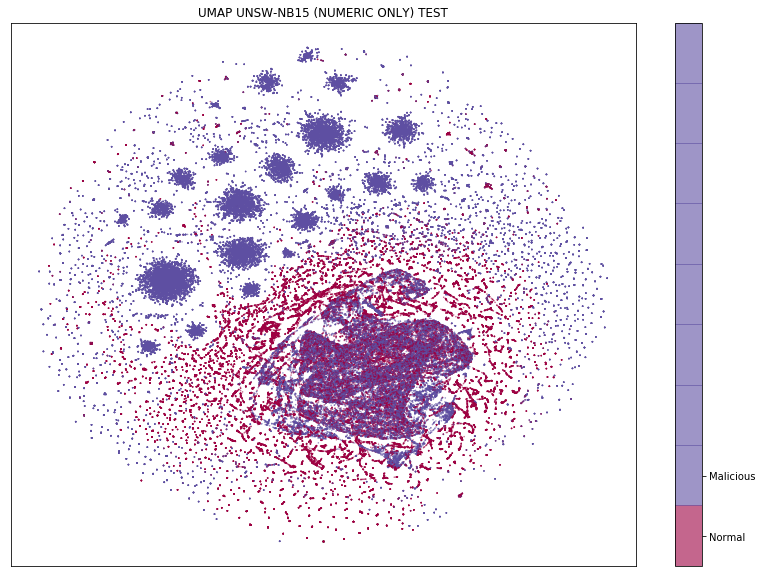

In [18]:
# Make Plot
classes = ['Normal', 'Malicious']
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=y_train, cmap='Spectral', alpha=0.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(10)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('UMAP UNSW-NB15 (NUMERIC ONLY) TEST')

In [16]:
y_train.count(0) / (y_train.count(1) + y_train.count(0))

0.3612033903567326